# Notebook for looking at photon yield / percentage for diff theta, phi

In [1]:
#imports
import numpy as np
import uproot as up
import pandas as pd
import matplotlib.pyplot as plot
from scipy.stats import norm
from scipy.optimize import curve_fit
import sympy
from IPython.display import clear_output
import math
import time
import util
#My imports
from util import PVect,get_layer,create_layer_map,theta_func,phi_func,findBin,bin_percent_theta_phi

In [2]:
particle = "mu"
energy = "5"
color_dict = {
    "pi" : "red",
    "mu" : "blue"
}

uproot_path = f"/cwork/rck32/eic/work_eic/root_files/June_17/variation_scint/mu_{energy}GeV_10kevents_file_0.edm4hep.root:events"
events = up.open(uproot_path)

x_pos_branch = events["HcalBarrelHits/HcalBarrelHits.position.x"].array(library='np')
EDep_branch = events["HcalBarrelHits.EDep"].array(library='np')
Pathlength_branch = events["HcalBarrelHits.pathLength"].array(library='np')
Hits_MC_idx_branch = events["_HcalBarrelHits_MCParticle.index"].array(library='np')
MC_parents = events["_MCParticles_parents.index"].array(library='np')
MC_daughters = events["MCParticles.daughters_end"].array(library='np')
PDG_branch = events["MCParticles.PDG"].array(library='np')
MC_endpoint_x_branch = events["MCParticles.endpoint.x"].array(library='np')
layer_map = [1830.8000, 1841.4000, 1907.5, 1918.1,1984.1999, 1994.8000, 2060.8999,2071.5,2137.6001,2148.1999,2214.3000,2224.8999,2291,2301.6001,2367.6999,2378.3000,2444.3999,2455,2521.1001,2531.6999,2597.8000,2608.3999,2674.5,2685.1001,2751.1999,2761.8000,2827.8999,2838.5]    

MC_px = events["MCParticles.momentum.x"].array(library='np')
MC_py = events["MCParticles.momentum.y"].array(library='np')
MC_pz = events["MCParticles.momentum.z"].array(library='np')
MC_m = events["MCParticles.mass"].array(library='np')

Idea: first find which super layer, then from there test if in first or second layer

In [3]:
layer_map,super_layer_map = create_layer_map()

# Calculate % of photons hitting sensor for diff theta phi bins

In [4]:
n_bins = 100

theta_min = 68
theta_max = 112
phi_min = -22
phi_max = 22

theta_range = theta_max - theta_min
phi_range = phi_max - phi_min

phi_bins = np.linspace(phi_min,phi_max,n_bins+1)
theta_bins = np.linspace(theta_min,theta_max,n_bins+1)

In [5]:
#works only for evenly spaced bins
def findBin(val,bins):
    diff = bins[1] - bins[0]
    rel_dist = val - bins[0]
    mod = np.floor(rel_dist / diff)
    return int(mod)

In [12]:
theta_edep = np.zeros(n_bins)
phi_edep = np.zeros(n_bins)

theta_path_length = np.zeros(n_bins)
phi_path_length = np.zeros(n_bins)

theta_counts = np.zeros(n_bins)
phi_counts = np.zeros(n_bins)

num_events = len(EDep_branch)
break_val = 10000
for event_idx in range(len(EDep_branch)):
    if(not (event_idx % (break_val // 100))):
        clear_output(wait = True)
        print(f"{event_idx // (break_val // 100)}% done")
#     if(event_idx > break_val):
#         break
    num_MC = 0
    primary = PVect()
    primary.setVector(MC_px[event_idx][0],MC_py[event_idx][0],MC_pz[event_idx][0],MC_m[event_idx][0])
    phi_bin = findBin(primary.phi,phi_bins)
    theta_bin = findBin(primary.theta,theta_bins)
    phi_counts[phi_bin]+=1
    theta_counts[theta_bin]+=1
    for i in range(len(EDep_branch[event_idx])):
        if(Hits_MC_idx_branch[event_idx][i] == 0):
            #sum up the edep
            theta_edep[theta_bin] += EDep_branch[event_idx][i]
            phi_edep[phi_bin] += EDep_branch[event_idx][i]
            
            theta_path_length[theta_bin] += Pathlength_branch[event_idx][i]
            phi_path_length[phi_bin] += Pathlength_branch[event_idx][i]
            

99% done


In [13]:
for i in range(n_bins):
    if(phi_counts[i] == 0):
        phi_edep[i] == -10
        phi_path_length[i] == -10
    else:
        phi_edep[i] = phi_edep[i] / phi_counts[i]
        phi_path_length[i] = phi_path_length[i] / phi_counts[i]
    
    if(theta_counts[i] == 0):
        theta_edep[i] == -10
        theta_path_length[i] == -10
    else:
        theta_edep[i] = theta_edep[i] / theta_counts[i]
        theta_path_length[i] = theta_path_length[i] / theta_counts[i]

In [15]:
theta_bin_centers = np.empty(n_bins)
phi_bin_centers = np.empty(n_bins)
for i in range(len(theta_bins) - 1):
    theta_bin_centers[i] = (theta_bins[i] + theta_bins[i+1]) / 2
    phi_bin_centers[i] = (phi_bins[i] + phi_bins[i+1]) / 2

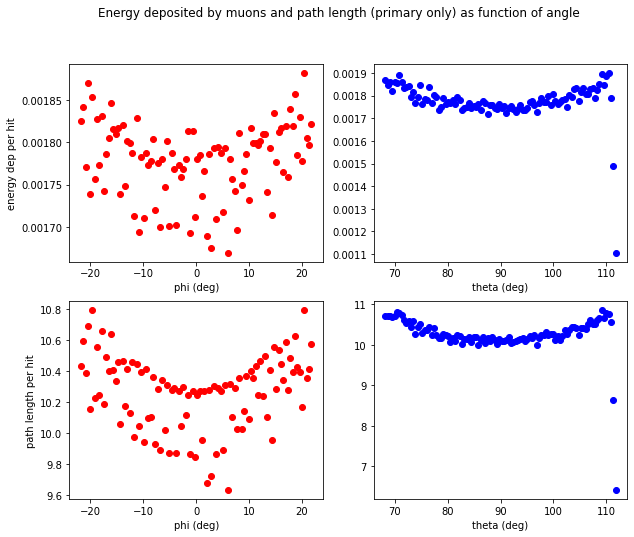

In [19]:
fig, ((ax1,ax2),(ax3,ax4)) = plot.subplots(2,2, figsize=(10,8))
fig.suptitle("Energy deposited by muons and path length (primary only) as function of angle")
ax1.scatter(phi_bin_centers,phi_edep,color="red")
ax1.set_xlabel("phi (deg)")
ax1.set_ylabel("energy dep per hit")
ax2.scatter(theta_bin_centers,theta_edep,color = "blue")
ax2.set_xlabel("theta (deg)")

ax3.scatter(phi_bin_centers,phi_path_length,color="red")
ax3.set_xlabel("phi (deg)")
ax3.set_ylabel("path length per hit")
ax4.scatter(theta_bin_centers,theta_path_length,color = "blue")
ax4.set_xlabel("theta (deg)")
fig.show()
# fig.savefig("plots/percentage/June_14_mu_5GeV_10k_phi_theta_20_bins.jpeg")

Fitting theta-% distribution

In [137]:
def exp_curve(x,a,b,c):
    return a * np.exp(-x * b) + c
def poly_8d(x,a,b,c,d,e,f,g,h,i):
    return a * x ** 8 + b * x ** 7 + c * x ** 6 + d * x ** 5 + e * x ** 4 + f * x ** 3 + g * x ** 2 + h * x + i 
def poly_2d(x,a,b,c):
    return a * x ** 2 + b * x + c
def inverse(x,a,b,c):
    return a  / (x + b) + c

In [138]:
popt_theta, pcov_theta = curve_fit(inverse,theta_bin_centers,theta_percent)

Text(0, 0.5, '% photons reaching sensor')

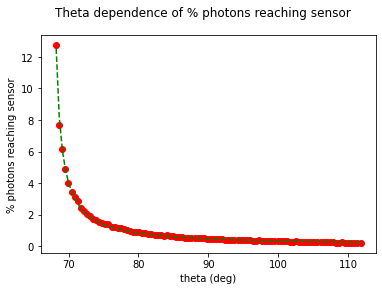

In [156]:
fig_theta, ax_theta = plot.subplots(1,1)
ax_theta.plot(theta_bin_centers, inverse(theta_bin_centers,*popt_theta), 'g--')
fig_theta.suptitle("Theta dependence of % photons reaching sensor")
ax_theta.scatter(theta_bin_centers,theta_percent,color="red")
ax_theta.set_xlabel("theta (deg)")
ax_theta.set_ylabel("% photons reaching sensor")
# fig_theta.legend()

In [157]:
popt_phi, pcov_phi = curve_fit(poly_2d,phi_bin_centers,phi_percent)

Text(0, 0.5, '% photons reaching sensor')

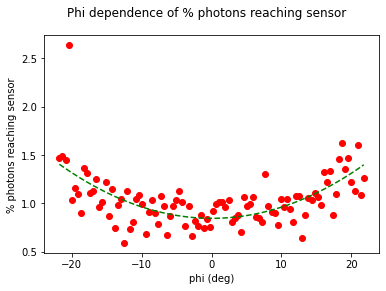

In [158]:
fig_phi, ax_phi = plot.subplots(1,1)
ax_phi.plot(phi_bin_centers, poly_2d(phi_bin_centers,*popt_phi), 'g--')
fig_phi.suptitle("Phi dependence of % photons reaching sensor")
ax_phi.scatter(phi_bin_centers,phi_percent,color="red")
ax_phi.set_xlabel("phi (deg)")
ax_phi.set_ylabel("% photons reaching sensor")
# fig_phi.legend()